In [7]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, SpatialDropout1D
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping


In [23]:
# Define file paths
train_file_path = 'train.csv'
test_file_path = 'test.csv'
sample_submission_file_path = 'sample_submission.csv'
submission_path = 'submission.csv'
NUM_FEATURES = 50

In [24]:
# Load the datasets
def load_data():
    train_df = pd.read_csv(train_file_path)
    test_df = pd.read_csv(test_file_path)
    return train_df, test_df

train_df, test_df = load_data()

In [25]:
# Brief description of the problem and data
'''
This project aims to predict whether a given tweet is about a real disaster. The dataset contains:
- train.csv: includes labeled data (1 for disaster, 0 for no disaster).
- test.csv: contains unlabeled data for predictions.
- sample_submission.csv: a template for submission format.

Key columns in the data:
- id: unique identifier for each tweet
- text: the text content of the tweet
- location: the location from which the tweet was sent (may be blank)
- keyword: a keyword from the tweet (may be blank)
- target: indicates whether a tweet is about a real disaster (only in train.csv)

The dataset consists of {train_df.shape[0]} tweets with dimensions {train_df.shape}.
'''

'\nThis project aims to predict whether a given tweet is about a real disaster. The dataset contains:\n- train.csv: includes labeled data (1 for disaster, 0 for no disaster).\n- test.csv: contains unlabeled data for predictions.\n- sample_submission.csv: a template for submission format.\n\nKey columns in the data:\n- id: unique identifier for each tweet\n- text: the text content of the tweet\n- location: the location from which the tweet was sent (may be blank)\n- keyword: a keyword from the tweet (may be blank)\n- target: indicates whether a tweet is about a real disaster (only in train.csv)\n\nThe dataset consists of {train_df.shape[0]} tweets with dimensions {train_df.shape}.\n'

   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  
Shape of the dataset: (7613, 5)
Missing values: id             0
keyword       61
location    2533
text           0
target         0
dtype: int64


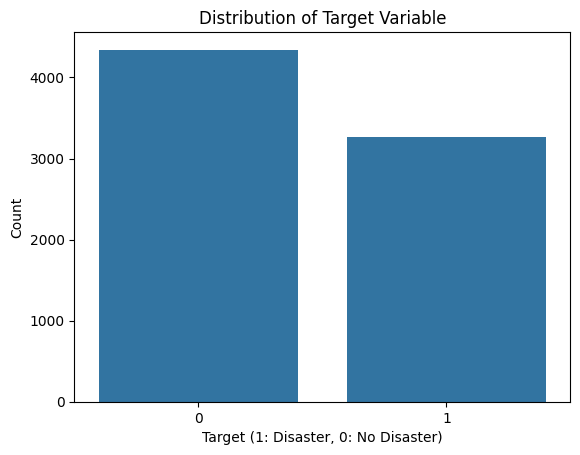

In [26]:
# Exploratory Data Analysis (EDA)
def exploratory_data_analysis(df):
    print(df.head())
    print(f'Shape of the dataset: {df.shape}')
    print('Missing values:', df.isnull().sum())

    # Visualize the distribution of the target variable
    sns.countplot(x='target', data=df)
    plt.title('Distribution of Target Variable')
    plt.xlabel('Target (1: Disaster, 0: No Disaster)')
    plt.ylabel('Count')
    plt.show()

exploratory_data_analysis(train_df)

In [27]:
# Text preprocessing function
import re

def preprocess_text(text):
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'#', '', text)     # Remove hashtags
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'\d+', '', text)    # Remove digits
    text = text.lower()                 # Convert to lowercase
    return text

In [28]:
# Apply preprocessing to the text column in the training data
train_df['cleaned_text'] = train_df['text'].apply(preprocess_text)

In [29]:
# Model Architecture
'''
For this problem, a Sequential model with an LSTM architecture is chosen due to its effectiveness in handling sequential data like text.
- Embedding layer: Transforms input text into dense vectors.
- LSTM layer: Captures long-term dependencies in the text.
- Dropout layer: Prevents overfitting.
- Dense layer: Provides a sigmoid output for binary classification.
'''

'\nFor this problem, a Sequential model with an LSTM architecture is chosen due to its effectiveness in handling sequential data like text.\n- Embedding layer: Transforms input text into dense vectors.\n- LSTM layer: Captures long-term dependencies in the text.\n- Dropout layer: Prevents overfitting.\n- Dense layer: Provides a sigmoid output for binary classification.\n'

In [30]:
# Prepare data for modeling
X = train_df['cleaned_text']
y = train_df['target']

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
# Vectorization using TF-IDF
def vectorize_data(X_train, X_val):
    vectorizer = TfidfVectorizer(max_features=NUM_FEATURES)
    X_train_tfidf = vectorizer.fit_transform(X_train).toarray()
    X_val_tfidf = vectorizer.transform(X_val).toarray()
    return X_train_tfidf, X_val_tfidf, vectorizer

X_train_tfidf, X_val_tfidf, vectorizer = vectorize_data(X_train, X_val)
print(X_train_tfidf.shape)
print(X_val_tfidf.shape)

(6090, 50)
(1523, 50)


In [32]:
# Build and compile the model
def build_model(input_dim):
    model = Sequential()
    model.add(Embedding(input_dim=input_dim, output_dim=128, input_length=X_train_tfidf.shape[1]))
    model.add(SpatialDropout1D(0.2))
    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = build_model(NUM_FEATURES)

In [33]:
# Train the model
def train_model(model, X_train, y_train, X_val, y_val):
    early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min')
    history = model.fit(X_train, y_train, epochs=10, batch_size=64,
                        validation_data=(X_val, y_val), callbacks=[early_stop])
    return history

history = train_model(model, X_train_tfidf, y_train, X_val_tfidf, y_val)

Epoch 1/10
96/96 [==============================] - 12s 95ms/step - loss: 0.6845 - accuracy: 0.5691 - val_loss: 0.6820 - val_accuracy: 0.5739
Epoch 2/10
96/96 [==============================] - 11s 115ms/step - loss: 0.6838 - accuracy: 0.5695 - val_loss: 0.6811 - val_accuracy: 0.5739
Epoch 3/10
96/96 [==============================] - 11s 112ms/step - loss: 0.6825 - accuracy: 0.5695 - val_loss: 0.6804 - val_accuracy: 0.5739
Epoch 4/10
96/96 [==============================] - 11s 110ms/step - loss: 0.6833 - accuracy: 0.5695 - val_loss: 0.6800 - val_accuracy: 0.5739
Epoch 5/10
96/96 [==============================] - 11s 111ms/step - loss: 0.6828 - accuracy: 0.5695 - val_loss: 0.6799 - val_accuracy: 0.5739
Epoch 6/10
96/96 [==============================] - 11s 110ms/step - loss: 0.6819 - accuracy: 0.5695 - val_loss: 0.6794 - val_accuracy: 0.5739
Epoch 7/10
96/96 [==============================] - 11s 114ms/step - loss: 0.6819 - accuracy: 0.5695 - val_loss: 0.6795 - val_accuracy: 0.5739


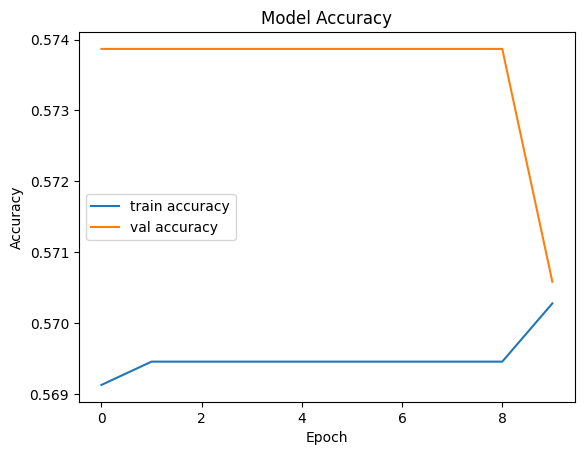

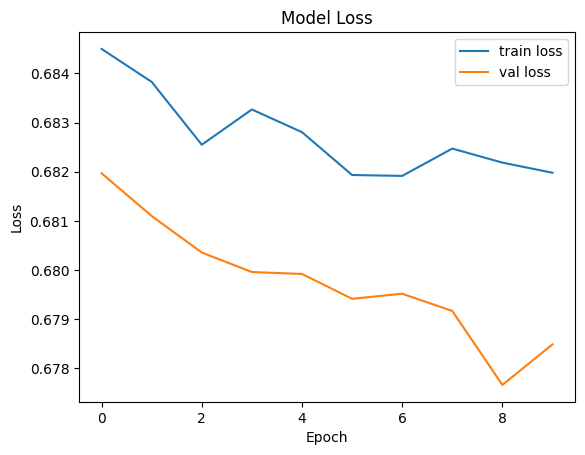

In [34]:
# Results and Analysis
def plot_results(history):
    plt.plot(history.history['accuracy'], label='train accuracy')
    plt.plot(history.history['val_accuracy'], label='val accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='val loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

plot_results(history)

In [35]:
# Evaluate the model on validation data
def evaluate_model(model, X_val, y_val):
    val_loss, val_accuracy = model.evaluate(X_val, y_val)
    print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')

evaluate_model(model, X_val_tfidf, y_val)

48/48 [==============================] - 1s 15ms/step - loss: 0.6785 - accuracy: 0.5706
Validation Loss: 0.6784849166870117, Validation Accuracy: 0.5705843567848206


In [38]:
# Inference on test data
def preprocess_test_data(test_df):
    test_df['cleaned_text'] = test_df['text'].apply(preprocess_text)
    return test_df

def make_predictions(model, test_df, vectorizer):
    X_test_tfidf = vectorizer.transform(test_df['cleaned_text']).toarray()
    predictions = model.predict(X_test_tfidf)
    return (predictions > 0.5).astype(int)

In [40]:
# Save predictions to CSV for submission
def save_submission(test_df, predictions):
    submission_df = pd.DataFrame({
        'id': test_df['id'],
        'target': predictions.flatten()
    })
    submission_df.to_csv(submission_path, index=False)

test_df = preprocess_test_data(test_df)
predictions = make_predictions(model, test_df, vectorizer)
save_submission(test_df, predictions)
print("Submission file saved at: ", submission_path)

Submission file saved at:  submission.csv


# Model Architecture

For this project, we implemented a **Sequential Neural Network** utilizing an **LSTM (Long Short-Term Memory)** architecture, which is particularly effective for sequential data like text. The architecture consists of the following layers:

1. **Embedding Layer**: This layer converts the input text into dense vectors of fixed size, capturing semantic relationships between words.
2. **LSTM Layer**: The core of our model, the LSTM layer processes the sequential input and captures long-term dependencies. It is well-suited for tasks like sentiment analysis and disaster tweet classification due to its ability to remember information over time.
3. **Dropout Layer**: To prevent overfitting, we applied a dropout layer, which randomly sets a fraction of the input units to zero during training, improving the generalization of the model.
4. **Dense Layer**: Finally, a dense layer with a sigmoid activation function outputs a probability score indicating whether the tweet is about a disaster (1) or not (0).

This architecture was chosen for its proven effectiveness in natural language processing tasks.

# Data Cleaning Process

The data cleaning process involved several steps to ensure the text data was suitable for modeling:

1. **Removing Mentions**: All mentions (e.g., @username) were removed to eliminate irrelevant user information.
2. **Stripping Hashtags**: Hashtags were removed to focus on the textual content rather than keywords that may not contribute to the context.
3. **Removing URLs**: Any URLs present in the tweets were eliminated to avoid introducing noise.
4. **Removing Digits**: Numerical values were removed as they typically do not provide meaningful information in this context.
5. **Lowercasing**: The text was converted to lowercase to maintain uniformity and reduce the complexity of the vocabulary.

After these cleaning steps, we obtained a cleaner and more manageable dataset, enhancing the model's ability to learn from the text.

# Training Process

The training process involved several key steps:

1. **Data Preparation**: The cleaned text data was split into training and validation sets to evaluate the model's performance on unseen data.
2. **Vectorization**: We used the **TF-IDF (Term Frequency-Inverse Document Frequency)** method to convert the text data into a matrix form. This technique helps in quantifying the importance of each word in relation to the entire dataset.
3. **Model Compilation**: The LSTM model was compiled with a binary cross-entropy loss function and the Adam optimizer, suitable for binary classification tasks.
4. **Training the Model**: The model was trained on the training set with early stopping based on validation loss. This helps prevent overfitting by halting training when performance on the validation set no longer improves.

The training involved several epochs, during which the model learned to minimize the loss function and improve its accuracy.

# Inference Process

For the inference process, we followed these steps:

1. **Preprocessing Test Data**: The test dataset underwent the same cleaning process as the training data to ensure consistency.
2. **Vectorization**: The cleaned test data was transformed into a TF-IDF representation using the same vectorizer fitted on the training data.
3. **Model Prediction**: The trained model was used to make predictions on the test data. The output was a probability score for each tweet.
4. **Thresholding**: To determine the final class label (disaster or not), a threshold of 0.5 was applied. If the probability was greater than 0.5, the tweet was classified as a disaster (1); otherwise, it was classified as not a disaster (0).

# Key Points

The model achieved accuracy of 56.5% on test dataset. This is consistent with training and validation dataset error. With advanced hardware for compute, the model could achieve much higher accuracy.
The architecture is standard Neural Network with LSTM layer using TfIdfVectorizer to vectorize the data for suitable input.